In [2]:
import pandas as pd
import numpy as np
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os 
from matplotlib.colors import ListedColormap
from PIL import Image

In [23]:
sns.set(style="whitegrid")

def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r"http\S+", "", texto)  # quitar URLs
    texto = re.sub(r"[^\w\s#@]", "", texto)  # quitar signos
    return texto

def extraer_hashtags(texto):
    return re.findall(r"#\w+", texto)

def analizar_comentarios_redes(
    text_series, 
    date_series, 
    likes_series=None, 
    shares_series=None, 
    comments_count_series=None,
    caption_series=None,
    author_series=None,
    author_comment_series=None,
    views_series=None,
    export_path=None
):
    # 1. Preprocesamiento inicial
    date_series = pd.to_datetime(date_series, errors='coerce')
    df = pd.DataFrame({
        'text': text_series.fillna('').astype(str).apply(limpiar_texto),
        'date': date_series
    })

    if likes_series is not None:
        df['likes'] = likes_series.fillna(0).astype(int)
    if shares_series is not None:
        df['shares'] = shares_series.fillna(0).astype(int)
    if comments_count_series is not None:
        df['comments_count'] = comments_count_series.fillna(0).astype(int)
    if caption_series is not None:
        df['caption'] = caption_series.fillna('').astype(str).apply(limpiar_texto)
        df['caption_hashtags'] = df['caption'].apply(extraer_hashtags)
    if author_series is not None:
        df['author'] = author_series.fillna('')
    if author_comment_series is not None:
        df['author_comment'] = author_comment_series.fillna('')
    if views_series is not None:
        df['views'] = views_series.fillna(0).astype(int)

    # 2. Variables temporales
    df['month'] = df['date'].dt.to_period("M")
    df['day'] = df['date'].dt.date
    df['hour'] = df['date'].dt.hour

    # 3. Hashtags
    df['hashtags'] = df['text'].apply(extraer_hashtags)
    all_hashtags = [tag for tags in df['hashtags'] for tag in tags]
    hashtag_freq = pd.Series(all_hashtags).value_counts().head(20)

    # 4. Emojis
    def extract_emojis(text):
        return [c for c in text if emoji.is_emoji(c)]

    df['emojis'] = df['text'].apply(extract_emojis)

    # 5. Sentimiento
    sid = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['sentiment_label'] = df['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral'
    )

    # 6. Clustering de temas
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['text'])
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['cluster'] = kmeans.fit_predict(tfidf_matrix)
    silhouette = silhouette_score(tfidf_matrix, df['cluster'])

    # 7. Métricas agregadas
    resumen = {
        'num_total_comentarios': len(df),
        'promedio_likes': df['likes'].mean() if 'likes' in df else None,
        'promedio_shares': df['shares'].mean() if 'shares' in df else None,
        'promedio_comentarios_por_post': df['comments_count'].mean() if 'comments_count' in df else None,
        'distribucion_sentimiento': df['sentiment_label'].value_counts(normalize=True).to_dict(),
        'silhouette_score_kmeans': silhouette
    }

    if 'views' in df:
        resumen['promedio_visualizaciones'] = df['views'].mean()

    # 8. Visualizaciones

    ## Wordcloud
    
    #RGB codes
    colors = ['#3A3A3C', '#D1D1D6', '#D4AF37', '#003B5C', '#F42C50', '#2C7A89', '#232C35']
    #Create personalized colormap
    custom_colormap = ListedColormap(colors)

    # Carga la imagen y conviértela en una máscara (blanco=área vacía, negro=texto)
    #img_mask = np.array(Image.open("/Users/tadeonava/Downloads/b&j.avif"))

  
    wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=1000, relative_scaling= 0.5, colormap=custom_colormap, random_state= 1).generate(' '.join(df['text']))
    #mask = img_mask 
    plt.figure(figsize=(6,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Topics in comments")
    plt.show()

    ## Sentimiento
    sns.countplot(data=df, x='sentiment_label', order=['positive', 'neutral', 'negative'])
    plt.title("Feeling distribution")
    plt.show()

    ## Comentarios por día
    df.groupby('day').size().plot(figsize=(12,4))
    plt.title("Comment volume by day")
    plt.ylabel("Cantidad")
    plt.xlabel("Fecha")
    plt.show()

    ## Hashtags más frecuentes
    hashtag_freq.plot(kind='barh', figsize=(8,6))
    plt.title("Hashtag usage")
    plt.gca().invert_yaxis()
    plt.show()
    #RGB codes
    colors = ['#3A3A3C', '#D1D1D6', '#D4AF37', '#003B5C', '#F42C50', '#2C7A89', '#232C35']
    custom_colormap = ListedColormap(colors)
    #img_mask = np.array(Image.open("/Users/tadeonava/Downloads/apple_logo.jpg"))
   # Crea una lista de todos los hashtags extraídos
    all_hashtags = [hashtag for hashtags_list in df['hashtags'] for hashtag in hashtags_list]
    
    # Genera la nube de hashtags
    wordcloud_hashtag = WordCloud(width=800, height=400, background_color="white", max_words=1000, 
                      relative_scaling=0.5, colormap=custom_colormap, random_state=1, regexp=r'#\w+').generate(' '.join(all_hashtags)) #mask=img_mask

    # Muestra la nube de hashtags
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud_hashtag, interpolation='bilinear')
    plt.axis("off")
    plt.title("Hashtag usage")
    plt.show()

    ## Distribución por hora
    sns.histplot(df['hour'], bins=24, kde=True)
    plt.title("Comment distribution per hour")
    plt.xlabel("Hora del Día")
    plt.show()

    # 8. Exportación
    if export_path:
        os.makedirs(os.path.dirname(export_path), exist_ok=True)
        
        # Resumen: Crear DataFrame para las métricas
        resumen_df = pd.DataFrame(list(resumen.items()), columns=['Métrica', 'Valor'])

        # Si el archivo es CSV, usa to_csv
        if export_path.endswith('.csv'):
            df.to_csv(export_path.replace('.csv', '_analisis.csv'), index=False)
            resumen_df.to_csv(export_path.replace('.csv', '_resumen.csv'), index=False)
        # Si el archivo es Excel, usa to_excel
        elif export_path.endswith('.xlsx'):
            df.to_excel(export_path.replace('.xlsx', '_analisis.xlsx'), index=False)
            resumen_df.to_excel(export_path.replace('.xlsx', '_resumen.xlsx'), index=False)
        
        print(f"Archivos exportados en: {export_path.replace('.csv', '_analisis.csv')}")
    
    return df, resumen

/var/folders/lh/k_ftm6zs6s7d3lhpy8ybqnj00000gp/T/ipykernel_1538/1791608773.py:48: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period("M")


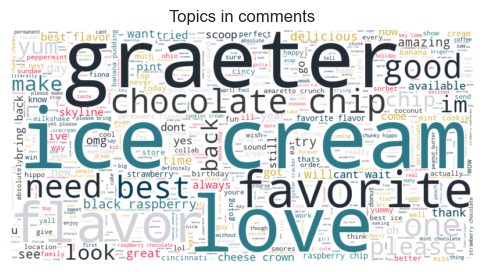

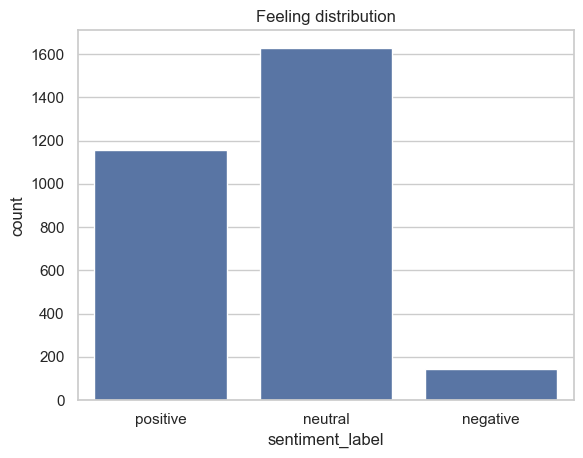

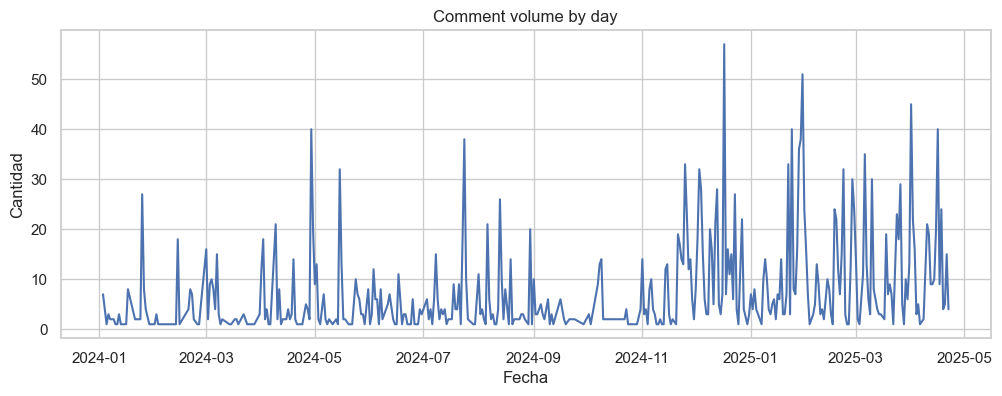

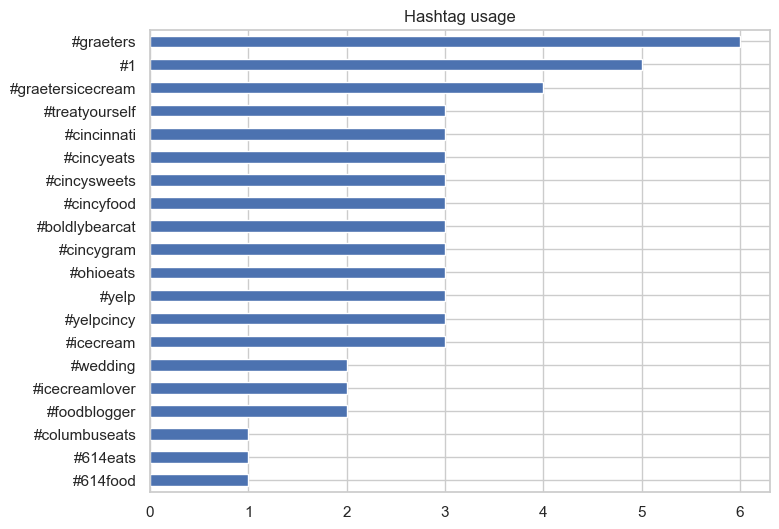

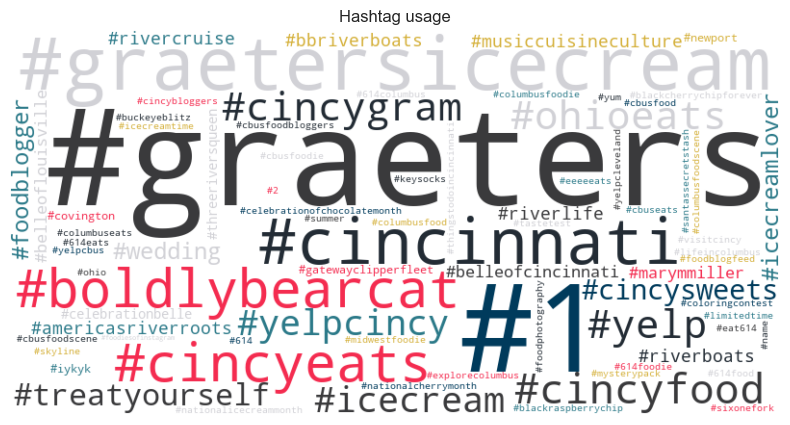

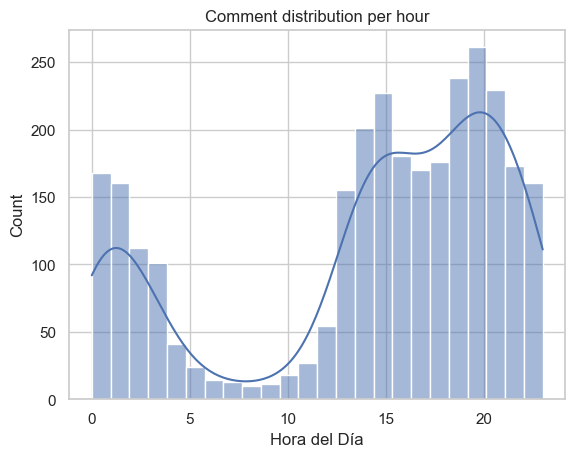

Archivos exportados en: /Users/tadeonava/Downloads/analisis_redes_analisis.csv


In [24]:
csv_path = '/Users/tadeonava/Downloads/Moose Tracks/Graeters dataset_instagram-comment-scraper_2025-04-22_23-16-29-276.csv'
df = pd.read_csv(csv_path)

# Personaliza tus columnas
text = df["text"] #could be posts or comments, preferently comments
date = df["timestamp"]
likes = df.get("likesCount")
#shares = df.get("shares")
#comments_count = df.get("comments_count")
#caption = df.get("topComments/0/text")

# Ejecuta el análisis y exporta
df_resultado, resumen = analizar_comentarios_redes(
    text_series=text,
    date_series=date,
    #likes_series=likes,
    #shares_series=shares,
    #comments_count_series=comments_count,
    #caption_series=caption,
    export_path="/Users/tadeonava/Downloads/analisis_redes.csv"  # ← aquí tu path
)




### Hashtag usage

In [25]:
import pandas as pd
import re

def calculate_hashtag_usage_rate(df):
    """
    Calculates the rate at which hashtags are used in a DataFrame with a 'comments' column.

    Args:
        df (pd.DataFrame): The DataFrame containing the comments data.

    Returns:
        float: The rate of hashtag usage (percentage of posts containing hashtags).
    """

    # Function to find hashtags in a string
    def find_hashtags(text):
        if isinstance(text, str):
            return re.findall(r"#\w+", text)  # Find hashtags (words starting with #)
        else:
            return []

    # Apply the function to the 'comments' column to find hashtags in each comment
    df['hashtags_found'] = text.apply(find_hashtags)

    # Count the number of posts that contain hashtags
    posts_with_hashtags = df['hashtags_found'].apply(len) > 0
    num_posts_with_hashtags = posts_with_hashtags.sum()

    # Calculate the hashtag usage rate
    total_posts = len(df)
    hashtag_usage_rate = (num_posts_with_hashtags / total_posts) * 100

    return hashtag_usage_rate



# Calculate the hashtag usage rate
usage_rate = calculate_hashtag_usage_rate(df)

# Print the result
print(f"Hashtag Usage Rate: {usage_rate:.2f}%")



Hashtag Usage Rate: 0.79%


/Users/tadeonava/Python/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9825 (\N{WHITE HEART SUIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tadeonava/Python/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9749 (\N{HOT BEVERAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tadeonava/Python/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tadeonava/Python/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129346 (\N{CLINKING GLASSES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


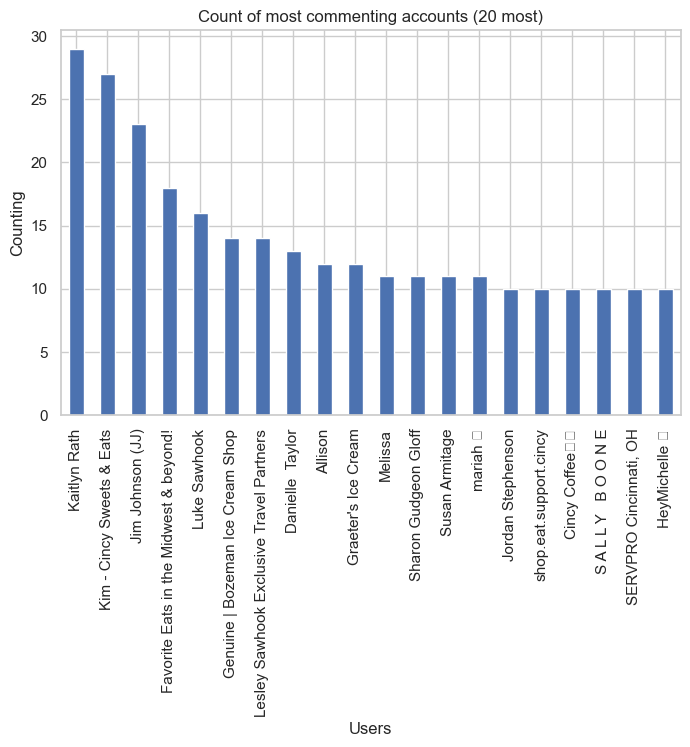

In [26]:
author = df['owner/full_name']
user_counts = author.value_counts().head(20)

# Create plot
plt.figure(figsize=(8, 5))  # Adjust size
user_counts.plot(kind='bar')
plt.xlabel('Users')
plt.ylabel('Counting')
plt.title('Count of most commenting accounts (20 most)')
plt.show()

## HASHTAGS

## Columns of Hashtags

In [17]:
#Hashtags 

from collections import Counter

def analyze_hashtags(df):
    """
    Analyzes hashtag usage in a DataFrame with columns like 'hashtag/0', 'hashtag/1', ..., 'hashtag/30'.

    Args:
        df (pd.DataFrame): The DataFrame containing the hashtag data.

    Returns:
        Counter: A Counter object containing the frequency of each hashtag.
    """

    hashtag_columns = [f"hashtags/{i}/name" for i in range(200)]  # Create a list of column names. EDIT THE NAME!!!

    all_hashtags = []
    for col in hashtag_columns:
        if col in df.columns:  # Check if the column exists
            all_hashtags.extend(df[col].dropna().tolist())  # Add hashtags to the list

    hashtag_counts = Counter(all_hashtags)  # Count hashtag frequencies
    #RGB codes
    colors = ["#c5b683ff","#68a3daff","#691b33ff"]

    # Crear el colormap personalizado
    custom_colormap = ListedColormap(colors)

    # Generar la wordcloud con el colormap personalizado
    wordcloud = WordCloud(width=600, height=400, background_color="black", max_words=50, relative_scaling=0.5, colormap=custom_colormap).generate_from_frequencies(hashtag_counts)

    # Display the word cloud
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("General Conversation based in Michigan Panthers", fontsize=16, fontweight='bold', color='black', font='Poppins')
    plt.axis('off')  # Hide axes
    plt.show()
    return hashtag_counts

#For just one column
'''
def analyze_hashtags(df):
    hashtag_counts = Counter(df)
    return hashtag_counts
'''

# Analyze the hashtags
hashtag_counts = analyze_hashtags(df)

# Get the most common hashtags
most_common_hashtags = hashtag_counts.most_common()

# Print the top 10 hashtags
print("\nHashtags Frequency:")
for hashtag, count in hashtag_counts.most_common():
    print(f"{hashtag}: {count}")


ValueError: We need at least 1 word to plot a word cloud, got 0.

## Extract hashtags from string


Top Hashtags:
#graeters: 6
#1: 5
#graetersicecream: 4
#cincinnati: 3
#cincyeats: 3
#cincyfood: 3
#cincygram: 3
#ohioeats: 3
#yelp: 3
#yelpcincy: 3
#icecream: 3
#treatyourself: 3
#cincysweets: 3
#BoldlyBearcat: 2
#icecreamlover: 2
#wedding: 2
#foodblogger: 2
#americasriverroots: 1
#musiccuisineculture: 1
#riverboats: 1
#riverlife: 1
#rivercruise: 1
#BBRiverboats: 1
#BelleofCincinnati: 1
#MaryMMiller: 1
#BelleofLouisville: 1
#CelebrationBelle: 1
#ThreeRiversQueen: 1
#GatewayClipperFleet: 1
#covington: 1
#newport: 1
#iykyk: 1
#blackcherrychipforever: 1
#NAME: 1
#keysocks: 1
#skyline: 1
#NationalCherryMonth: 1
#CelebrationOfChocolateMonth: 1
#2: 1
#buckeyeblitz: 1
#blackraspberrychip: 1
#boldlybearcat: 1
#SantasSecretStash: 1
#yum: 1
#visitcincy: 1
#nationalicecreammonth: 1
#thingstodoincincinnati: 1
#cincybloggers: 1
#coloringcontest: 1
#ohio: 1
#midwestfoodie: 1
#cbusfoodie: 1
#cbusfoodbloggers: 1
#614columbus: 1
#columbusfoodie: 1
#614: 1
#614eats: 1
#614food: 1
#614foodie: 1
#eat614: 

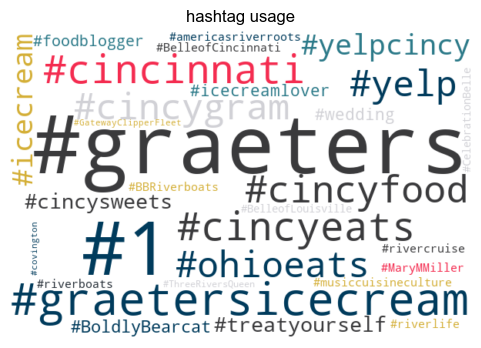

In [22]:
from collections import Counter
#Extract Hashtags from a string
def extraer_hashtags_y_generar_wordcloud(dataframe,hashtag):
    """
    Extrae hashtags de una columna de un DataFrame y genera una wordcloud.

    Args:
        dataframe (pd.DataFrame): DataFrame que contiene los datos.
    """
    hashtags = []
    for texto in dataframe.astype(str):  # Asegura que sea string
        if isinstance(texto, str):
            hashtags.extend(re.findall(r"#\w+", texto))  # Encuentra hashtags


    #Count HASHTAG frequency
    hashtag_counts = Counter(hashtags)

    print("\nTop Hashtags:")
    for hashtag, count in hashtag_counts.most_common():     
        print(f"{hashtag}: {count}")
    
    #RGB codes
    colors = ['#3A3A3C', '#D1D1D6', '#D4AF37', '#003B5C', '#F42C50', '#2C7A89', '#232C35']

    #Create personalized colormap
    custom_colormap = ListedColormap(colors)
    #img_mask = np.array(Image.open("/Users/tadeonava/Downloads/apple_logo.jpg")) #To use a background with logo
   
    #Generate WordCloud graph
    wordcloud = WordCloud(width=600, height=400, background_color="white", max_words=30, relative_scaling= 0.5, colormap=custom_colormap, random_state= 1).generate_from_frequencies(hashtag_counts) #mask = img_mask
#IF YOU WANT TO SEE MORE WORDS TRY MODIFYING relative_scaling

    # Display the word cloud
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("hashtag usage", fontsize=16, fontweight='bold', color='black', font='arial') 
    plt.axis('off')  # Hide axes
    plt.show()
    return 

all_hashtags = 0
extraer_hashtags_y_generar_wordcloud(text,all_hashtags)